# Libraries

In [47]:
# Libraries
import pandas as pd
import re
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Gathering the Data

In [4]:
# Read Excel Sheets
path_directory = "data-analyst-task.xlsx" # file path
doc = pd.read_excel(path_directory, sheet_name=None) # all sheets in excel

# df for different sheets
march_df = doc['March']
april_df = doc['April']
may_df = doc['May']
lookup_df = doc['MASTER_LOOKUP']

# add Month coloumn to identify month of the data
march_df["Month"] = "March"
april_df["Month"] = "April"
may_df["Month"] = "May"

# Concat all 3 months
df = pd.concat([march_df, april_df, may_df], ignore_index=True)
df_copy = df.copy()
lookup_df_copy = lookup_df.copy()

In [5]:
# Group by 'Content Name' and 'Month', then sum the 'Views'
grouped_views = df_copy.groupby(['Content Name', 'Month'])['Views'].sum().reset_index()

# Rename column for clarity
grouped_views = grouped_views.rename(columns={"Views": "Total_Views"})

display(grouped_views.head())

,Content Name,Month,Total_Views
0,#Dead2Me (s1): ep 01 (HD),April,114
1,#Dead2Me (s1): ep 01 (HD),March,116
2,#Dead2Me (s1): ep 01 (HD),May,100
3,#Dead2Me (s1): ep 02 (HD),April,68
4,#Dead2Me (s1): ep 02 (HD),March,55


In [6]:
# Create working copy
df = grouped_views.copy()

# Initialize all parsed columns as NaN
df["parsed_title"] = pd.NA
df["parsed_season"] = pd.NA
df["parsed_episode"] = pd.NA
df["parsed_quality"] = pd.NA
df["parsed_episode_title"] = pd.NA
df["pattern_rule"] = pd.NA

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29515 entries, 0 to 29514
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Content Name          29515 non-null  object
 1   Month                 29515 non-null  object
 2   Total_Views           29515 non-null  int64 
 3   parsed_title          0 non-null      object
 4   parsed_season         0 non-null      object
 5   parsed_episode        0 non-null      object
 6   parsed_quality        0 non-null      object
 7   parsed_episode_title  0 non-null      object
 8   pattern_rule          0 non-null      object
dtypes: int64(1), object(8)
memory usage: 2.0+ MB


# Identifing the Patterns

In [8]:
# --- Pattern 1: #?Title (sX): ep YY (Quality) ---
pattern1 = r"(?P<title>#?.+?)\s+\(s(?P<season>\d+)\):\s+ep\s+(?P<episode>\d+)\s+\((?P<quality>.+?)\)"
match1 = df["Content Name"].str.extract(pattern1)

# Create a mask for rows that matched the pattern
mask1 = match1["title"].notna()

# Fill extracted values only for matched rows
df.loc[mask1, "parsed_title"] = match1.loc[mask1, "title"]
df.loc[mask1, "parsed_season"] = match1.loc[mask1, "season"]
df.loc[mask1, "parsed_episode"] = match1.loc[mask1, "episode"]
df.loc[mask1, "parsed_quality"] = match1.loc[mask1, "quality"]
df.loc[mask1, "pattern_rule"] = 1

# Summary statistics
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=1 is", len(df[df["pattern_rule"] == 1]))
print("The number of unparsed rows is", len(df_unparsed))

# Show only the rows matched by this pattern
display(df[df["pattern_rule"] == 1].head())

The number of rows is 29515
The number of parsed rows is 13391
The number of pattern_rule=1 is 13391
The number of unparsed rows is 16124


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
0,#Dead2Me (s1): ep 01 (HD),April,114,#Dead2Me,1,01,HD,<NA>,1
1,#Dead2Me (s1): ep 01 (HD),March,116,#Dead2Me,1,01,HD,<NA>,1
2,#Dead2Me (s1): ep 01 (HD),May,100,#Dead2Me,1,01,HD,<NA>,1
3,#Dead2Me (s1): ep 02 (HD),April,68,#Dead2Me,1,02,HD,<NA>,1
4,#Dead2Me (s1): ep 02 (HD),March,55,#Dead2Me,1,02,HD,<NA>,1


In [9]:
# --- Pattern 2: #?Title : Episode Title : Episode Number ---
# Apply only to rows where parsed_title is still missing
mask2 = df["parsed_title"].isna()

# Define regex pattern
pattern2 = r"(?P<title2>#[^:]+)\s*:\s*(?P<ep_title>[^:]+)\s*:\s*(?P<episode2>\d+)"

# Apply regex extraction to the masked rows
match2 = df.loc[mask2, "Content Name"].str.extract(pattern2)

# Fill the extracted values only where applicable
df.loc[mask2, "parsed_title"] = match2["title2"]
df.loc[mask2, "parsed_episode_title"] = match2["ep_title"]
df.loc[mask2, "parsed_episode"] = df.loc[mask2, "parsed_episode"].fillna(match2["episode2"])
df.loc[mask2, "pattern_rule"] = 2

# Update parsed/unparsed statistics
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", 29515)
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=2 is", len(df[df["pattern_rule"] == 2]))
print("The number of unparsed rows is", len(df_unparsed))

# Display only the rows matched by this pattern
display(df[df["pattern_rule"] == 2].head())


The number of rows is 29515
The number of parsed rows is 13487
The number of pattern_rule=2 is 16124
The number of unparsed rows is 16028


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
27,#Dead2Me : Ahmad : 3,April,181,#Dead2Me,<NA>,3,<NA>,Ahmad,2
28,#Dead2Me : Ahmad : 3,March,3,#Dead2Me,<NA>,3,<NA>,Ahmad,2
29,#Dead2Me : Ahmad : 3,May,61,#Dead2Me,<NA>,3,<NA>,Ahmad,2
30,#Dead2Me : Bendall : 1,April,271,#Dead2Me,<NA>,1,<NA>,Bendall,2
31,#Dead2Me : Bendall : 1,March,9,#Dead2Me,<NA>,1,<NA>,Bendall,2


In [10]:
# --- Pattern 3 (updated): Multi-colon title : ep XX (Quality) ---
# Apply only to rows where parsed_title is still missing
mask3 = df["parsed_title"].isna()

# Define regex pattern (with optional season in parentheses)
pattern3 = r"^(?P<title3>.+?)\s*(\((?P<season3>s\d+)\))?\s*:\s*ep\s*(?P<episode3>\d+)\s*\((?P<quality3>.+?)\)$"

# Apply regex to the masked rows
match3 = df.loc[mask3, "Content Name"].str.extract(pattern3)

# Only keep matched rows
matched_mask3 = match3["title3"].notna()
matched_indices3 = match3[matched_mask3].index

# Fill in extracted values
df.loc[matched_indices3, "parsed_title"] = match3.loc[matched_mask3, "title3"].str.strip()
df.loc[matched_indices3, "parsed_season"] = match3.loc[matched_mask3, "season3"].str.extract(r"(\d+)")  # just number
df.loc[matched_indices3, "parsed_episode"] = match3.loc[matched_mask3, "episode3"]
df.loc[matched_indices3, "parsed_quality"] = match3.loc[matched_mask3, "quality3"]
df.loc[matched_indices3, "pattern_rule"] = 3

# Update parsed/unparsed stats
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=3 rows is", len(df[df['pattern_rule'] == 3]))
print("The number of unparsed rows is", len(df_unparsed))

# Display only rows matched by this pattern
display(df[df["pattern_rule"] == 3].head())

The number of rows is 29515
The number of parsed rows is 13549
The number of pattern_rule=3 rows is 62
The number of unparsed rows is 15966


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
1212,Al Murray: Why Does Everyon : ep 01 (HD),April,17,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1213,Al Murray: Why Does Everyon : ep 01 (HD),March,30,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1214,Al Murray: Why Does Everyon : ep 01 (HD),May,12,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1215,Al Murray: Why Does Everyon : ep 02 (HD),April,6,Al Murray: Why Does Everyon,NaN,02,HD,NaN,3
1216,Al Murray: Why Does Everyon : ep 02 (HD),March,12,Al Murray: Why Does Everyon,NaN,02,HD,NaN,3


In [11]:
# Fill missing parsed_season using info from 'Content Name' if available
season_fix_mask = (df['pattern_rule'] == 3) & (df['parsed_season'].isna())
season_extracted = df.loc[season_fix_mask, 'Content Name'].str.extract(r'\(s(\d+)\)')
df.loc[season_fix_mask, 'parsed_season'] = season_extracted[0]
display(df[df["pattern_rule"] == 3].head())

,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
1212,Al Murray: Why Does Everyon : ep 01 (HD),April,17,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1213,Al Murray: Why Does Everyon : ep 01 (HD),March,30,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1214,Al Murray: Why Does Everyon : ep 01 (HD),May,12,Al Murray: Why Does Everyon,NaN,01,HD,NaN,3
1215,Al Murray: Why Does Everyon : ep 02 (HD),April,6,Al Murray: Why Does Everyon,NaN,02,HD,NaN,3
1216,Al Murray: Why Does Everyon : ep 02 (HD),March,12,Al Murray: Why Does Everyon,NaN,02,HD,NaN,3


In [12]:
# --- Pattern 4: #?Title (sX): Episode Title (Quality) ---
# Apply only where parsed_title is still missing
mask4 = df["parsed_title"].isna()

# Define regex
pattern4 = r"#?(?P<title4>.+?)\s+\(s(?P<season4>\d+)\):\s+(?P<ep_title4>.+?)\s+\((?P<quality4>.+?)\)"

# Apply regex only to masked rows
match4 = df.loc[mask4, "Content Name"].str.extract(pattern4)

# Only keep matched rows
matched_mask4 = match4["title4"].notna()
matched_indices4 = match4[matched_mask4].index

# Fill in only matched rows
df.loc[matched_indices4, "parsed_title"] = match4.loc[matched_mask4, "title4"]
df.loc[matched_indices4, "parsed_season"] = match4.loc[matched_mask4, "season4"]
df.loc[matched_indices4, "parsed_episode_title"] = match4.loc[matched_mask4, "ep_title4"]
df.loc[matched_indices4, "parsed_quality"] = match4.loc[matched_mask4, "quality4"]
df.loc[matched_indices4, "pattern_rule"] = 4

# Update parsed/unparsed stats
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=4 rows is", len(df[df['pattern_rule'] == 4]))
print("The number of unparsed rows is", len(df_unparsed))

# Display only rows matched by this pattern
display(df[df["pattern_rule"] == 4].head())

The number of rows is 29515
The number of parsed rows is 15267
The number of pattern_rule=4 rows is 1718
The number of unparsed rows is 14248


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
452,999 Killer on The Line (s1): Crymbl (HD),April,127,999 Killer on The Line,1,NaN,HD,Crymbl,4
453,999 Killer on The Line (s1): Crymbl (HD),March,91,999 Killer on The Line,1,NaN,HD,Crymbl,4
454,999 Killer on The Line (s1): Crymbl (HD),May,556,999 Killer on The Line,1,NaN,HD,Crymbl,4
455,999 Killer on The Line (s1): Evans (HD),April,109,999 Killer on The Line,1,NaN,HD,Evans,4
456,999 Killer on The Line (s1): Evans (HD),March,55,999 Killer on The Line,1,NaN,HD,Evans,4


In [13]:
# --- Pattern 5.2: Title: Episode (Quality)
# -----------------------------
mask5_2 = df["parsed_title"].isna()
subset5_2 = df.loc[mask5_2, "Content Name"].astype(str).str.strip()
subset5_2 = subset5_2[subset5_2.str.contains(":")]  # Speed up by pre-filtering

pattern5_2 = r"^(?P<title5_2>[^:]+):\s*(?P<episode5_2>.+?)\s*\((?P<quality5_2>.+?)\)$"
match5_2 = subset5_2.str.extract(pattern5_2)

matched_mask5_2 = match5_2["title5_2"].notna()
matched_indices5_2 = match5_2[matched_mask5_2].index

df.loc[matched_indices5_2, "parsed_title"] = match5_2.loc[matched_mask5_2, "title5_2"]
df.loc[matched_indices5_2, "parsed_episode_title"] = match5_2.loc[matched_mask5_2, "episode5_2"]
df.loc[matched_indices5_2, "parsed_quality"] = df.loc[matched_indices5_2, "parsed_quality"].fillna(match5_2.loc[matched_mask5_2, "quality5_2"])
df.loc[matched_indices5_2, "pattern_rule"] = 5.2


# -----------------------------
# --- Pattern 5.1: Title (Quality)
# -----------------------------
mask5_1 = df["parsed_title"].isna()
subset5_1 = df.loc[mask5_1, "Content Name"].astype(str).str.strip()

pattern5_1 = r"^(?P<title5_1>.+?)\s+\((?P<quality5_1>.+?)\)$"
match5_1 = subset5_1.str.extract(pattern5_1)

matched_mask5_1 = match5_1["title5_1"].notna()
matched_indices5_1 = match5_1[matched_mask5_1].index

df.loc[matched_indices5_1, "parsed_title"] = match5_1.loc[matched_mask5_1, "title5_1"]
df.loc[matched_indices5_1, "parsed_quality"] = df.loc[matched_indices5_1, "parsed_quality"].fillna(match5_1.loc[matched_mask5_1, "quality5_1"])
df.loc[matched_indices5_1, "pattern_rule"] = 5.1


# -----------------------------
# --- Statistics and Preview ---
# -----------------------------
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("Total rows:", len(df))
print("Parsed rows:", len(df_parsed))
print("Pattern 5.1 matches:", len(df[df["pattern_rule"] == 5.1]))
print("Pattern 5.2 matches:", len(df[df["pattern_rule"] == 5.2]))
print("Unparsed rows:", len(df_unparsed))

display(df[df["pattern_rule"].isin([5.1, 5.2])].head(10))

Total rows: 29515
Parsed rows: 15338
Pattern 5.1 matches: 16
Pattern 5.2 matches: 55
Unparsed rows: 14177


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
654,A Serial Killer In Nazi Paris (HD),May,214,A Serial Killer In Nazi Paris,<NA>,NaN,HD,NaN,5.1
1176,Al Murray: America (HD),April,5,Al Murray,<NA>,NaN,HD,America,5.2
1177,Al Murray: America (HD),March,6,Al Murray,<NA>,NaN,HD,America,5.2
1178,Al Murray: America (HD),May,15,Al Murray,<NA>,NaN,HD,America,5.2
1179,Al Murray: France (HD),April,27,Al Murray,<NA>,NaN,HD,France,5.2
1180,Al Murray: France (HD),March,45,Al Murray,<NA>,NaN,HD,France,5.2
1181,Al Murray: France (HD),May,59,Al Murray,<NA>,NaN,HD,France,5.2
1182,Al Murray: Germany (HD),April,10,Al Murray,<NA>,NaN,HD,Germany,5.2
1183,Al Murray: Germany (HD),March,18,Al Murray,<NA>,NaN,HD,Germany,5.2
1184,Al Murray: Germany (HD),May,41,Al Murray,<NA>,NaN,HD,Germany,5.2


In [14]:
# Manual title/episode fixes for pattern_rule == 5.2
mask_52 = df["pattern_rule"] == 5.2

# 1. Al Murray → Full title fix
df.loc[mask_52 & (df['parsed_title'].str.lower() == 'al murray'), 'parsed_title'] = "Al Murray: Why Does Everyone Hate The British Empire?"

# 2. Battle Of Britain
df.loc[mask_52 & (df['Content Name'] == 'Battle Of Britain: Race For Radar (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Battle Of Britain - The Race For The Radar'] * 2

# 3. Battlefield Healers
df.loc[mask_52 & (df['Content Name'] == 'Battlefield Healers: Bosworth Field (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Battlefield Healers: Bosworth Field'] * 2

# 4. Beyond The Headlines: Catching The
df.loc[mask_52 & (df['Content Name'] == 'Beyond The Headlines: Catching The (HD)'), 'parsed_title'] = 'Beyond The Headlines: Catching The'

# 5. Beyond The Headlines: The Carlina W
df.loc[mask_52 & (df['Content Name'] == 'Beyond The Headlines: The Carlina W (HD)'), 'parsed_title'] = 'Beyond The Headlines: The Carlina W'

# 6. Beyond The Headlines: The Tanya Kac
df.loc[mask_52 & (df['Content Name'] == 'Beyond The Headlines: The Tanya Kac (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Beyond The Headlines: The Tanya Kac'] * 2

# 7. Beyond The Headlines: The Tiffany R
df.loc[mask_52 & (df['Content Name'] == 'Beyond The Headlines: The Tiffany R (HD)'), 'parsed_title'] = 'Beyond The Headlines: The Tiffany R'

# 8. Beyond the Headlines: Black Girl Mi
df.loc[mask_52 & (df['Content Name'] == 'Beyond the Headlines: Black Girl Mi (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Beyond the Headlines: Black Girl Mi'] * 2

# 9. Black Patriots
df.loc[mask_52 & (df['Content Name'] == 'Black Patriots: Heroes Of The Civil (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Black Patriots: Heroes Of The Civil'] * 2

# 10. Cutty Sark
df.loc[mask_52 & (df['Content Name'] == 'Cutty Sark: Out Of The Ashes (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Cutty Sark: Out Of The Ashes'] * 2

# 11. Elizabeth Shoaf
df.loc[mask_52 & (df['Content Name'] == 'Elizabeth Shoaf: The Girl In A Bunk (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Elizabeth Shoaf: The Girl In A Bunk'] * 2

# 12. Fear Thy Neighbor
df.loc[mask_52 & (df['Content Name'] == 'Fear Thy Neighbor (s4):Lust to Dust (HD)'), ['parsed_title', 'parsed_season']] = ['fear thy neighbor', '4']

# 13. Mary Kay Letourneau
df.loc[mask_52 & (df['Content Name'] == 'Mary Kay Letourneau: Autobiography (HD)'), ['parsed_title', 'parsed_episode_title']] = ['Mary Kay Letourneau: Autobiography'] * 2

# 14. The Butcher
df.loc[mask_52 & (df['Content Name'] == "The Butcher (s1): Raising The Steaks(HD)"), ['parsed_title', 'parsed_season']] = ['The Butcher', '1']

# 15. UFOs
df.loc[mask_52 & (df['Content Name'] == 'UFOs: The White House Files (HD)'), ['parsed_title', 'parsed_episode_title']] = ['UFOs: The White House Files'] * 2

# 16. The Tattooist's Son
df.loc[mask_52 & (df['Content Name'] == "The Tattooist's Son: Journey To.. (HD)"), ['parsed_title', 'parsed_episode_title']] = ["The Tattooist's Son: Journey To.."] * 2

display((df[df["pattern_rule"] == 5.2]).head())

,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
1176,Al Murray: America (HD),April,5,Al Murray: Why Does Everyone Hate The British ...,<NA>,NaN,HD,America,5.2
1177,Al Murray: America (HD),March,6,Al Murray: Why Does Everyone Hate The British ...,<NA>,NaN,HD,America,5.2
1178,Al Murray: America (HD),May,15,Al Murray: Why Does Everyone Hate The British ...,<NA>,NaN,HD,America,5.2
1179,Al Murray: France (HD),April,27,Al Murray: Why Does Everyone Hate The British ...,<NA>,NaN,HD,France,5.2
1180,Al Murray: France (HD),March,45,Al Murray: Why Does Everyone Hate The British ...,<NA>,NaN,HD,France,5.2


In [15]:
# --- Pattern 6: Title : Episode Title (with colon) : Episode Number ---
# Apply only where parsed_title is still missing
mask6 = df["parsed_title"].isna()

# Define regex pattern that matches three colon-separated parts
pattern6 = r"^(?P<title6>[^:]+)\s*:\s*(?P<ep_title6>.+)\s*:\s*(?P<episode6>\d+)$"

# Apply regex extraction to the masked rows
match6 = df.loc[mask6, "Content Name"].str.extract(pattern6)

# Identify matched rows
matched_mask6 = match6["title6"].notna()
matched_indices6 = match6[matched_mask6].index

# Fill parsed columns only where match was successful
df.loc[matched_indices6, "parsed_title"] = match6.loc[matched_mask6, "title6"].str.strip()
df.loc[matched_indices6, "parsed_episode_title"] = match6.loc[matched_mask6, "ep_title6"].str.strip()
df.loc[matched_indices6, "parsed_episode"] = match6.loc[matched_mask6, "episode6"].str.strip()
df.loc[matched_indices6, "pattern_rule"] = 6

# Update stats
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=6 rows is", len(df[df['pattern_rule'] == 6]))
print("The number of unparsed rows is", len(df_unparsed))

# Show sample matches
display(df[df["pattern_rule"] == 6].head())

The number of rows is 29515
The number of parsed rows is 29139
The number of pattern_rule=6 rows is 13801
The number of unparsed rows is 376


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
198,60 Days In : After the 60 Days: Part Two : 12,April,28,60 Days In,<NA>,12,<NA>,After the 60 Days: Part Two,6
199,60 Days In : After the 60 Days: Part Two : 12,March,39,60 Days In,<NA>,12,<NA>,After the 60 Days: Part Two,6
200,60 Days In : After the 60 Days: Part Two : 12,May,51,60 Days In,<NA>,12,<NA>,After the 60 Days: Part Two,6
201,60 Days In : Before the 60 Days : 2023060844,April,3,60 Days In,<NA>,2023060844,<NA>,Before the 60 Days,6
202,60 Days In : Before the 60 Days : 2023060844,March,21,60 Days In,<NA>,2023060844,<NA>,Before the 60 Days,6


In [16]:
# --- Pattern 7: Title (sX): ep YY (Quality     [Missing closing parenthesis] ---
# Apply only where parsed_title is still missing
mask7 = df["parsed_title"].isna()

# Define regex to capture title, season, episode, and quality without needing the closing parenthesis
pattern7 = r"^(?P<title7>.+?)\s+\(s(?P<season7>\d+)\):\s+ep\s+(?P<episode7>\d+)\s+\((?P<quality7>.+?)$"

# Apply regex only to the masked rows
match7 = df.loc[mask7, "Content Name"].str.extract(pattern7)

# Identify only matched rows
matched_mask7 = match7["title7"].notna()
matched_indices7 = match7[matched_mask7].index

# Fill only matched entries
df.loc[matched_indices7, "parsed_title"] = match7.loc[matched_mask7, "title7"].str.strip()
df.loc[matched_indices7, "parsed_season"] = match7.loc[matched_mask7, "season7"].str.strip()
df.loc[matched_indices7, "parsed_episode"] = match7.loc[matched_mask7, "episode7"].str.strip()
df.loc[matched_indices7, "parsed_quality"] = match7.loc[matched_mask7, "quality7"].str.strip()
df.loc[matched_indices7, "pattern_rule"] = 7

# Update stats
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=7 rows is", len(df[df['pattern_rule'] == 7]))
print("The number of unparsed rows is", len(df_unparsed))

# Show sample matched rows
display(df[df["pattern_rule"] == 7].head())

The number of rows is 29515
The number of parsed rows is 29145
The number of pattern_rule=7 rows is 6
The number of unparsed rows is 370


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
25945,The Jennifer Dulos Story (s1): ep 01 (HD,April,186,The Jennifer Dulos Story,1,01,HD,NaN,7
25946,The Jennifer Dulos Story (s1): ep 01 (HD,March,201,The Jennifer Dulos Story,1,01,HD,NaN,7
25947,The Jennifer Dulos Story (s1): ep 01 (HD,May,193,The Jennifer Dulos Story,1,01,HD,NaN,7
25954,The Kamiyah Mobley Story (s1): ep 01 (HD,April,123,The Kamiyah Mobley Story,1,01,HD,NaN,7
25955,The Kamiyah Mobley Story (s1): ep 01 (HD,March,110,The Kamiyah Mobley Story,1,01,HD,NaN,7


In [17]:
# --- Pattern 8: Title with Season and Episode Info ---
# Apply only to rows where parsed_title is still missing
mask8 = df["parsed_title"].isna()

# Define the regex pattern: Capture full title, season (sX), and episode (ep XX)
pattern8 = r"^(?P<title8>.+?)\s+\(s(?P<season8>\d+)\):\s*ep\s*(?P<episode8>\d+)\s*"

# Extract matching values only from masked rows
match8 = df.loc[mask8, "Content Name"].str.extract(pattern8)

# Identify rows where title was successfully extracted
matched_mask8 = match8["title8"].notna()
matched_indices8 = match8[matched_mask8].index

# Fill extracted values into the corresponding parsed columns
df.loc[matched_indices8, "parsed_title"] = match8.loc[matched_mask8, "title8"].str.strip()
df.loc[matched_indices8, "parsed_season"] = match8.loc[matched_mask8, "season8"].str.strip()
df.loc[matched_indices8, "parsed_episode"] = match8.loc[matched_mask8, "episode8"].str.strip()
df.loc[matched_indices8, "pattern_rule"] = 8

# Update statistics
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=8 rows is", len(df[df['pattern_rule'] == 8]))
print("The number of unparsed rows is", len(df_unparsed))

# Display rows matched by pattern 8
display(df[df["pattern_rule"] == 8].head())

The number of rows is 29515
The number of parsed rows is 29148
The number of pattern_rule=8 rows is 3
The number of unparsed rows is 367


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
21039,Roswell 75: The Final E (s1): ep 01 : Roswell ...,April,15,Roswell 75: The Final E,1,01,<NA>,NaN,8
21040,Roswell 75: The Final E (s1): ep 01 : Roswell ...,March,31,Roswell 75: The Final E,1,01,<NA>,NaN,8
21041,Roswell 75: The Final E (s1): ep 01 : Roswell ...,May,24,Roswell 75: The Final E,1,01,<NA>,NaN,8


In [18]:
# Roswell 75
df.loc[
    (df["pattern_rule"] == 8) & (df["Content Name"] == 'Roswell 75: The Final E (s1): ep 01 : Roswell 75 1'),
    'parsed_episode_title'
] = 'roswell 75: the final e'

In [19]:
# --- Pattern 9: Fallback – Copy Content Name to parsed_title if unmatched ---
# Apply only to rows where parsed_title is still missing
mask9 = df["parsed_title"].isna()

# Copy 'Content Name' to 'parsed_title' for unmatched rows
df.loc[mask9, "parsed_title"] = df.loc[mask9, "Content Name"]
df.loc[mask9, "pattern_rule"] = 9

# Update statistics
df_parsed = df[df["parsed_title"].notna()]
df_unparsed = df[df["parsed_title"].isna()]

print("The number of rows is", len(df))
print("The number of parsed rows is", len(df_parsed))
print("The number of pattern_rule=9 rows is", len(df[df['pattern_rule'] == 9]))
print("The number of unparsed rows is", len(df_unparsed))

# Display rows matched by pattern 9
display(df[df["pattern_rule"] == 9].head())

The number of rows is 29515
The number of parsed rows is 29515
The number of pattern_rule=9 rows is 367
The number of unparsed rows is 0


,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
54,#FindGabby,April,16,#FindGabby,<NA>,NaN,<NA>,NaN,9
55,#FindGabby,March,52,#FindGabby,<NA>,NaN,<NA>,NaN,9
56,#FindGabby,May,17,#FindGabby,<NA>,NaN,<NA>,NaN,9
446,9/11: The Legacy,April,19,9/11: The Legacy,<NA>,NaN,<NA>,NaN,9
447,9/11: The Legacy,March,23,9/11: The Legacy,<NA>,NaN,<NA>,NaN,9


In [20]:
df.loc[df["pattern_rule"] == 9, "parsed_episode_title"] = df.loc[df["pattern_rule"] == 9, "parsed_title"]
display(df[df["pattern_rule"] == 9].head())

,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule
54,#FindGabby,April,16,#FindGabby,<NA>,NaN,<NA>,#FindGabby,9
55,#FindGabby,March,52,#FindGabby,<NA>,NaN,<NA>,#FindGabby,9
56,#FindGabby,May,17,#FindGabby,<NA>,NaN,<NA>,#FindGabby,9
446,9/11: The Legacy,April,19,9/11: The Legacy,<NA>,NaN,<NA>,9/11: The Legacy,9
447,9/11: The Legacy,March,23,9/11: The Legacy,<NA>,NaN,<NA>,9/11: The Legacy,9


# Standardization

In [22]:
# Step 1: Convert all text to lowercase
df['parsed_title'] = df['parsed_title'].astype(str).str.lower()
lookup_df['PROGRAMME_TITLE'] = lookup_df['PROGRAMME_TITLE'].astype(str).str.lower()

df['parsed_episode_title'] = df['parsed_episode_title'].astype(str).str.lower()
lookup_df['EPISODE_TITLE'] = lookup_df['EPISODE_TITLE'].astype(str).str.lower()

# Step 2: Remove leading/trailing whitespaces and normalize multiple spaces
df['parsed_title'] = df['parsed_title'].str.strip().str.replace(r'\s+', ' ', regex=True)
lookup_df['PROGRAMME_TITLE'] = lookup_df['PROGRAMME_TITLE'].str.strip().str.replace(r'\s+', ' ', regex=True)

df['parsed_episode_title'] = df['parsed_episode_title'].str.strip().str.replace(r'\s+', ' ', regex=True)
lookup_df['EPISODE_TITLE'] = lookup_df['EPISODE_TITLE'].str.strip().str.replace(r'\s+', ' ', regex=True)


# Step 3: Remove empty or null strings (optional, for performance)
df = df[df['parsed_title'].str.strip().astype(bool)]
lookup_df = lookup_df[lookup_df['PROGRAMME_TITLE'].str.strip().astype(bool)]

df = df[df['parsed_episode_title'].str.strip().astype(bool)]
lookup_df = lookup_df[lookup_df['EPISODE_TITLE'].str.strip().astype(bool)]

# Step 4: Replace placeholder '..' values with NaN
df.replace('..', pd.NA, inplace=True)

# Fuzzy Matching - Content Name

In [24]:
# --- Step 1: Ensure all input strings are properly converted to string type ---
df['parsed_title'] = df['parsed_title'].astype(str)
lookup_df['PROGRAMME_TITLE'] = lookup_df['PROGRAMME_TITLE'].astype(str)

# --- Step 2: Prepare list of lookup titles ---
lookup_titles = lookup_df['PROGRAMME_TITLE'].tolist()
df2 = df.copy()
matches = []

# --- Step 3: Loop through df2 and apply partial fuzzy matching ---
for i, row in df2.iterrows():
    query = row['parsed_title']
    
    match_result = process.extractOne(
        query,
        lookup_titles,
        scorer=fuzz.token_set_ratio

    )
    
    if match_result:
        matched_title, score, match_index = match_result
        matches.append({
            'index': i,  # Original row index
            'content_name': query,
            'matched_programme_title': matched_title,
            'match_score': score
        })

# --- Step 4: Create a DataFrame from matching results ---
match_df = pd.DataFrame(matches)

# --- Step 5: Merge the match results back into the original dataframe ---
df2['matched_programme_title'] = None
df2['match_score'] = None

for _, row in match_df.iterrows():
    df2.at[row['index'], 'matched_programme_title'] = row['matched_programme_title']
    df2.at[row['index'], 'match_score'] = row['match_score']

# --- Step 6: View first few results with matched titles and scores ---
print(df2[['parsed_title', 'matched_programme_title', 'match_score']].head(10))

  parsed_title matched_programme_title match_score
0     #dead2me                #dead2me       100.0
1     #dead2me                #dead2me       100.0
2     #dead2me                #dead2me       100.0
3     #dead2me                #dead2me       100.0
4     #dead2me                #dead2me       100.0
5     #dead2me                #dead2me       100.0
6     #dead2me                #dead2me       100.0
7     #dead2me                #dead2me       100.0
8     #dead2me                #dead2me       100.0
9     #dead2me                #dead2me       100.0


# Fuzy Matching - Episode Tittle

In [26]:
# --- Step 7: Prepare for EPISODE_TITLE matching (Program-specific) ---
df2['parsed_episode_title'] = df2['parsed_episode_title'].astype(str)
lookup_df['EPISODE_TITLE'] = lookup_df['EPISODE_TITLE'].astype(str)

episode_matches = []

# --- Step 8: Fuzzy match each episode title within its matched programme only ---
for i, row in df2.iterrows():
    episode_query = row['parsed_episode_title']
    programme = row['matched_programme_title']
    
    # Skip if no valid episode or programme
    if not episode_query or not programme or \
       episode_query.strip().lower() in ['nan', '', 'na', 'n/a'] or \
       len(episode_query.strip()) <= 2:
        continue
    
    # Filter candidate episodes for that programme only
    candidate_episodes = lookup_df[lookup_df['PROGRAMME_TITLE'] == programme]['EPISODE_TITLE'].dropna().tolist()
    if not candidate_episodes:
        continue

    match_result = process.extractOne(
        episode_query,
        candidate_episodes,
        scorer=fuzz.token_set_ratio
    )
    
    if match_result:
        matched_episode, score, _ = match_result
        episode_matches.append({
            'index': i,
            'matched_episode_title': matched_episode,
            'episode_match_score': score
        })

# --- Step 9: Assign episode matches to df2 ---
df2['matched_episode_title'] = None
df2['episode_match_score'] = None

for row in episode_matches:
    df2.at[row['index'], 'matched_episode_title'] = row['matched_episode_title']
    df2.at[row['index'], 'episode_match_score'] = row['episode_match_score']

# --- Step 10: Final preview ---
print(df2[['parsed_title', 'matched_programme_title', 'match_score',
           'parsed_episode_title', 'matched_episode_title', 'episode_match_score']].head(10))


  parsed_title matched_programme_title match_score parsed_episode_title  \
0     #dead2me                #dead2me       100.0                 <na>   
1     #dead2me                #dead2me       100.0                 <na>   
2     #dead2me                #dead2me       100.0                 <na>   
3     #dead2me                #dead2me       100.0                 <na>   
4     #dead2me                #dead2me       100.0                 <na>   
5     #dead2me                #dead2me       100.0                 <na>   
6     #dead2me                #dead2me       100.0                 <na>   
7     #dead2me                #dead2me       100.0                 <na>   
8     #dead2me                #dead2me       100.0                 <na>   
9     #dead2me                #dead2me       100.0                 <na>   

  matched_episode_title episode_match_score  
0           thomas nutt           26.666667  
1           thomas nutt           26.666667  
2           thomas nutt           26

In [27]:
# Safer filtering: handles both NaN and meaningless values in the parsed_episode_title column
mask_invalid = df2['parsed_episode_title'].isna() | df2['parsed_episode_title'].str.strip().str.lower().isin(['', 'nan', '<na>'])
df2.loc[mask_invalid, 'episode_match_score'] = None
df2.loc[mask_invalid, 'matched_episode_title'] = None
df2.head()

,Content Name,Month,Total_Views,parsed_title,parsed_season,parsed_episode,parsed_quality,parsed_episode_title,pattern_rule,matched_programme_title,match_score,matched_episode_title,episode_match_score
0,#Dead2Me (s1): ep 01 (HD),April,114,#dead2me,1,01,HD,<na>,1,#dead2me,100.0,None,None
1,#Dead2Me (s1): ep 01 (HD),March,116,#dead2me,1,01,HD,<na>,1,#dead2me,100.0,None,None
2,#Dead2Me (s1): ep 01 (HD),May,100,#dead2me,1,01,HD,<na>,1,#dead2me,100.0,None,None
3,#Dead2Me (s1): ep 02 (HD),April,68,#dead2me,1,02,HD,<na>,1,#dead2me,100.0,None,None
4,#Dead2Me (s1): ep 02 (HD),March,55,#dead2me,1,02,HD,<na>,1,#dead2me,100.0,None,None


# Filtering with Threshold

In [29]:
# 1. Identify rows where parsed_episode_title is NaN, '<na>', or empty
mask_episode_na = df2['parsed_episode_title'].astype(str).str.strip().str.lower().isin(['nan', '<na>', ''])

# 2. If episode title is filled, require both match_score ≥ 60 and episode_match_score ≥ 80
condition1 = (~mask_episode_na) & (df2['match_score'] >= 60) & (df2['episode_match_score'] >= 80)

# 3. If episode title is missing, include without further filtering
condition2 = mask_episode_na

# 4. Combine both
final_mask = condition1 | condition2

# 5. Apply filter
filtered_df = df2[final_mask].copy() #24825 entries/29514

# Select the specified columns
selected_columns = [
    "Month", 
    "Total_Views", 
    "matched_programme_title", 
    "matched_episode_title",
    "parsed_season", 
    "parsed_episode", 
    "parsed_quality"
]
final_output_df = filtered_df[selected_columns]

display(final_output_df.head())

,Month,Total_Views,matched_programme_title,matched_episode_title,parsed_season,parsed_episode,parsed_quality
0,April,114,#dead2me,None,1,01,HD
1,March,116,#dead2me,None,1,01,HD
2,May,100,#dead2me,None,1,01,HD
3,April,68,#dead2me,None,1,02,HD
4,March,55,#dead2me,None,1,02,HD


# Merge with Lookup Table

In [37]:
# Ensure EPISODE_TITLE is treated as string to avoid type comparison errors
lookup_df_copy["EPISODE_TITLE"] = lookup_df_copy["EPISODE_TITLE"].astype(str)

# Step 0: Remove duplicates from lookup – only keep unique episode-title combinations
# Count how many times each (programme, episode) pair appears
duplicate_keys = lookup_df_copy.groupby(['PROGRAMME_TITLE', 'EPISODE_TITLE']).size().reset_index(name='count')

# Find duplicated pairs
duplicated_pairs = duplicate_keys[duplicate_keys['count'] > 1][['PROGRAMME_TITLE', 'EPISODE_TITLE']]

# Label which rows are duplicates
lookup_df_copy['is_duplicated'] = lookup_df_copy.set_index(['PROGRAMME_TITLE', 'EPISODE_TITLE']) \
    .index.isin(duplicated_pairs.set_index(['PROGRAMME_TITLE', 'EPISODE_TITLE']).index)

# Remove duplicated entries
lookup_filtered = lookup_df_copy[~lookup_df_copy['is_duplicated']]

In [39]:
# Step 1: Normalize strings in matched columns
final_output_df.loc[:, 'matched_programme_title'] = final_output_df['matched_programme_title'].astype(str).str.lower().str.strip()
final_output_df.loc[:, 'matched_episode_title'] = final_output_df['matched_episode_title'].astype(str).str.lower().str.strip()

lookup_df_copy['PROGRAMME_TITLE'] = lookup_df_copy['PROGRAMME_TITLE'].astype(str).str.lower().str.strip()
lookup_df_copy['EPISODE_TITLE'] = lookup_df_copy['EPISODE_TITLE'].astype(str).str.lower().str.strip()

# replace multiple spaces/tabs with a single space
def clean_text(s):
    if pd.isnull(s):
        return s
    # Replace all whitespace characters (space, tab, newline) with a single space
    return re.sub(r'\s+', ' ', str(s)).strip().lower()

# Apply normalization to matched columns in final_output_df (safe assignment using .loc)
final_output_df.loc[:, 'matched_programme_title'] = final_output_df['matched_programme_title'].apply(clean_text)
final_output_df.loc[:, 'matched_episode_title'] = final_output_df['matched_episode_title'].apply(clean_text)

# Apply the same normalization to lookup columns
lookup_filtered.loc[:, 'PROGRAMME_TITLE'] = lookup_filtered['PROGRAMME_TITLE'].apply(clean_text)
lookup_filtered.loc[:, 'EPISODE_TITLE'] = lookup_filtered['EPISODE_TITLE'].apply(clean_text)

# Step 2: Set parsed columns as object (for consistency and null handling)
final_output_df.loc[:, 'parsed_season'] = final_output_df['parsed_season'].astype("object")
final_output_df.loc[:, 'parsed_episode'] = final_output_df['parsed_episode'].astype("object")

# Step 3: Merge with lookup to retrieve episode and season info
merged_df = pd.merge(
    final_output_df,
    lookup_filtered[['PROGRAMME_TITLE', 'EPISODE_TITLE', 'SEASON_NUMBER', 'EPISODE_NUMBER']],
    left_on=['matched_programme_title', 'matched_episode_title'],
    right_on=['PROGRAMME_TITLE', 'EPISODE_TITLE'],
    how='left'
)

# Step 4: Fill parsed_season and parsed_episode only if missing
merged_df['parsed_season'] = merged_df['SEASON_NUMBER'].combine_first(merged_df['parsed_season'])
merged_df['parsed_episode'] = merged_df['EPISODE_NUMBER'].combine_first(merged_df['parsed_episode'])

# Step 5: Clean up extra columns
merged_df.drop(columns=['PROGRAMME_TITLE', 'EPISODE_TITLE', 'SEASON_NUMBER', 'EPISODE_NUMBER'], inplace=True)

# Final updated dataframe
final_output_df = merged_df
final_output_df.head()

,Month,Total_Views,matched_programme_title,matched_episode_title,parsed_season,parsed_episode,parsed_quality
0,April,114,#dead2me,none,1,01,HD
1,March,116,#dead2me,none,1,01,HD
2,May,100,#dead2me,none,1,01,HD
3,April,68,#dead2me,none,1,02,HD
4,March,55,#dead2me,none,1,02,HD


In [41]:
# Filter rows where both parsed_season and parsed_episode are not null
final_df = final_output_df[
    final_output_df['parsed_season'].notna() & final_output_df['parsed_episode'].notna()
].reset_index(drop=True)  # Reset index and drop old index

# Display the result
display(final_df.head())
display(final_df.info())

,Month,Total_Views,matched_programme_title,matched_episode_title,parsed_season,parsed_episode,parsed_quality
0,April,114,#dead2me,none,1,01,HD
1,March,116,#dead2me,none,1,01,HD
2,May,100,#dead2me,none,1,01,HD
3,April,68,#dead2me,none,1,02,HD
4,March,55,#dead2me,none,1,02,HD


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24684 entries, 0 to 24683
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    24684 non-null  object
 1   Total_Views              24684 non-null  int64 
 2   matched_programme_title  24684 non-null  object
 3   matched_episode_title    24684 non-null  object
 4   parsed_season            24684 non-null  object
 5   parsed_episode           24684 non-null  object
 6   parsed_quality           14571 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


None

In [43]:
# Group by Month, Programme Title, Season, and Episode
final_df_without_quality = final_df.groupby(
    ['Month', 'matched_programme_title', 'parsed_season', 'parsed_episode'],
    as_index=False
)['Total_Views'].sum()
display(final_df_without_quality.head())

,Month,matched_programme_title,parsed_season,parsed_episode,Total_Views
0,April,#dead2me,1,1.0,271
1,April,#dead2me,1,2.0,236
2,April,#dead2me,1,3.0,181
3,April,#dead2me,1,4.0,154
4,April,#dead2me,1,5.0,139


# Analysing the Final Data

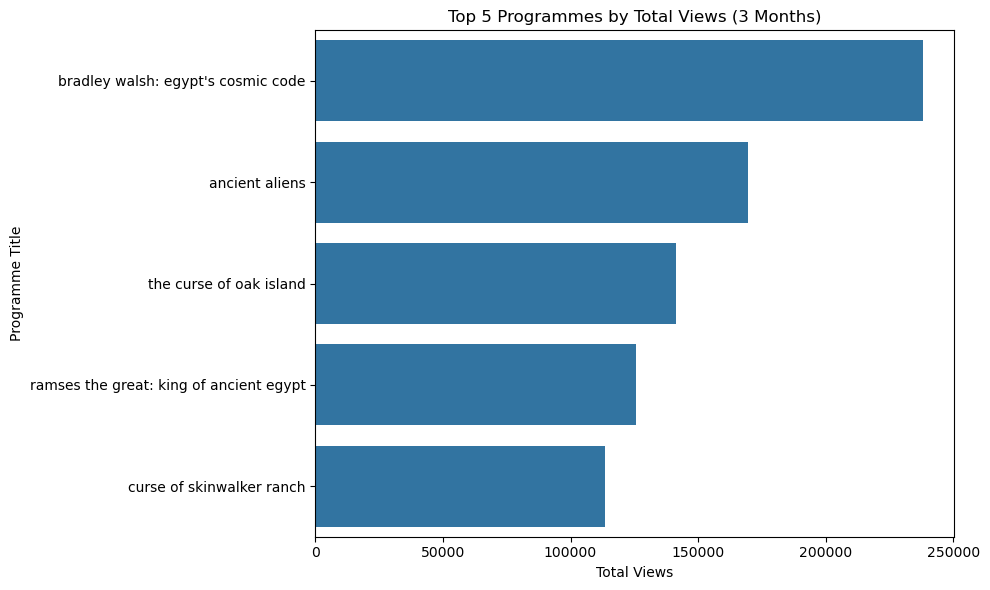

In [49]:
# Total Views per Top 5 Programmes
top_5_programmes = final_df_without_quality.groupby("matched_programme_title")["Total_Views"].sum().sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_programmes, x="Total_Views", y="matched_programme_title")
plt.title("Top 5 Programmes by Total Views (3 Months)")
plt.xlabel("Total Views")
plt.ylabel("Programme Title")
plt.tight_layout()
plt.show()

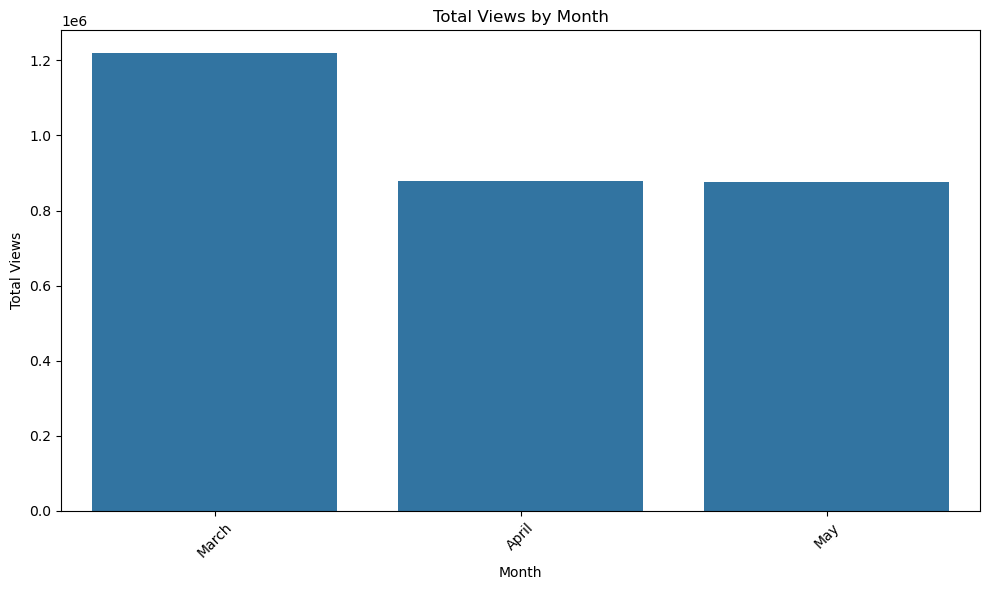

In [51]:
# Total Views per Month
monthly_views = final_df_without_quality.groupby("Month")["Total_Views"].sum().reset_index()
month_order = ["March", "April", "May"]
monthly_views["Month"] = pd.Categorical(monthly_views["Month"], categories=month_order, ordered=True)
monthly_views = monthly_views.sort_values("Month")

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_views, x="Month", y="Total_Views")
plt.title("Total Views by Month")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()

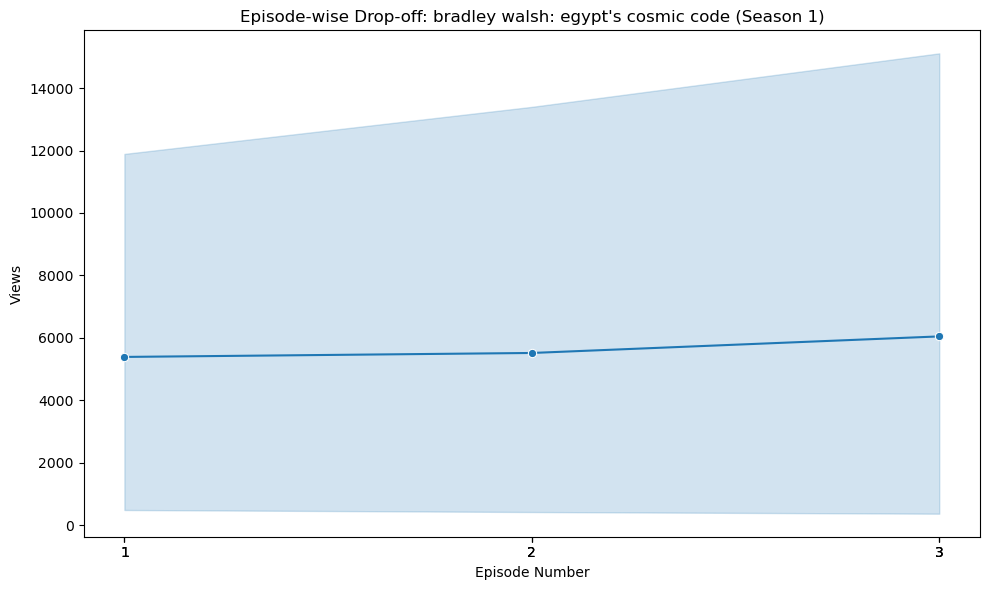

In [53]:
# Drop-off analysis for Season 1 of most viewed programme
most_viewed_title = top_5_programmes["matched_programme_title"].iloc[0]
season1_episodes = final_df_without_quality[(final_df_without_quality["matched_programme_title"] == most_viewed_title) & 
                                            (final_df_without_quality["parsed_season"] == '1')].copy()
season1_episodes["parsed_episode"] = season1_episodes["parsed_episode"].astype(int)
season1_episodes = season1_episodes.sort_values(by="parsed_episode")

plt.figure(figsize=(10, 6))
sns.lineplot(data=season1_episodes, x="parsed_episode", y="Total_Views", marker='o')
plt.title(f"Episode-wise Drop-off: {most_viewed_title} (Season 1)")
plt.xlabel("Episode Number")
plt.ylabel("Views")
plt.xticks(season1_episodes["parsed_episode"])
plt.tight_layout()
plt.show()

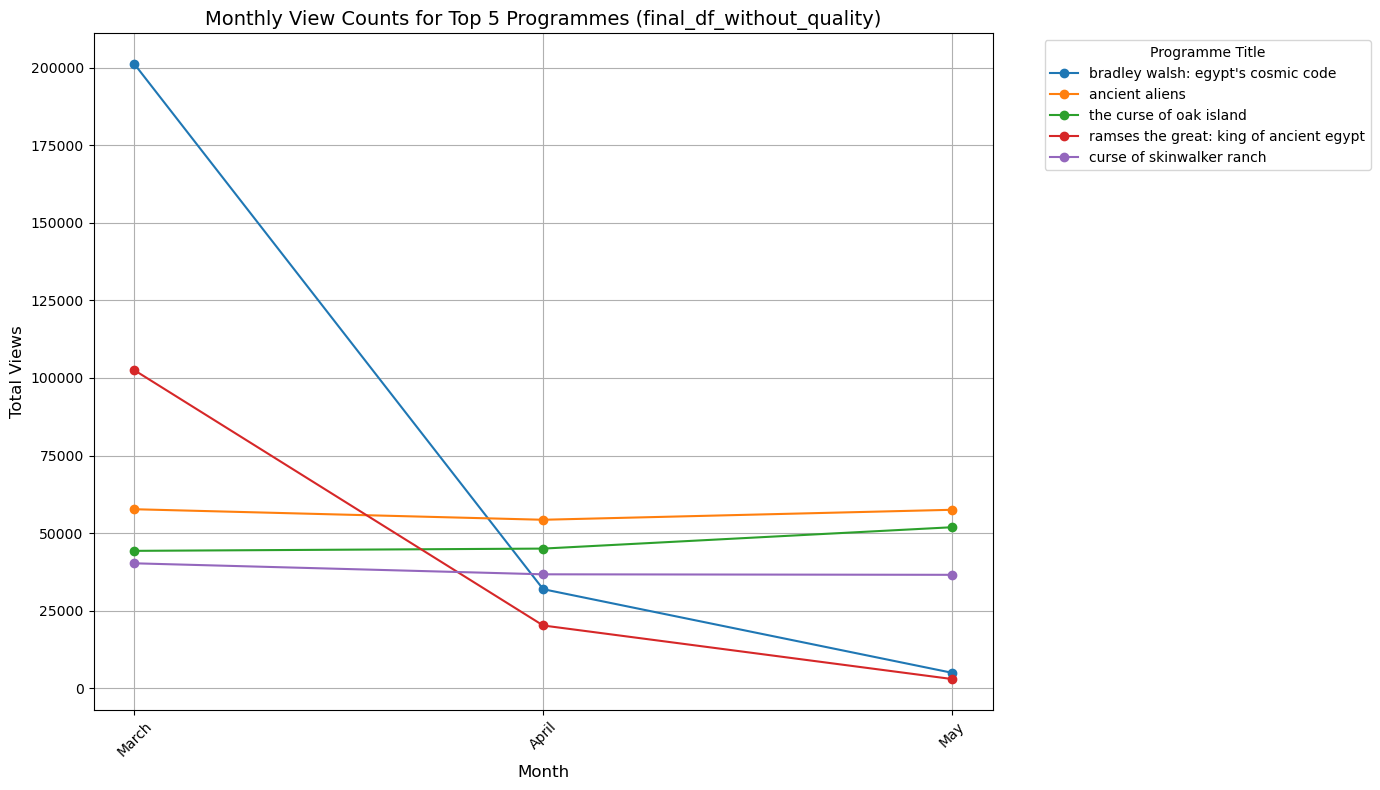

In [55]:
# Monthly View Counts for Top 5 Programmes 
# Prepare monthly view data for top 5 programmes
top_5_titles = top_5_programmes["matched_programme_title"].tolist()

# Filter dataset for only top 5 programmes
top_5_df = final_df_without_quality[final_df_without_quality["matched_programme_title"].isin(top_5_titles)]

# Group by Month and Programme Title
monthly_views_5 = top_5_df.groupby(["Month", "matched_programme_title"])["Total_Views"].sum().reset_index()

# Ensure chronological month order
monthly_views_5["Month"] = pd.Categorical(monthly_views_5["Month"], categories=month_order, ordered=True)
monthly_views_5 = monthly_views_5.sort_values("Month")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot monthly views for each programme
for title in top_5_titles:
    programme_data = monthly_views_5[monthly_views_5["matched_programme_title"] == title]
    ax.plot(programme_data["Month"], programme_data["Total_Views"], marker='o', label=title)

# Set title and labels
ax.set_title("Monthly View Counts for Top 5 Programmes (final_df_without_quality)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Total Views", fontsize=12)

# Add legend and formatting
ax.legend(title="Programme Title", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


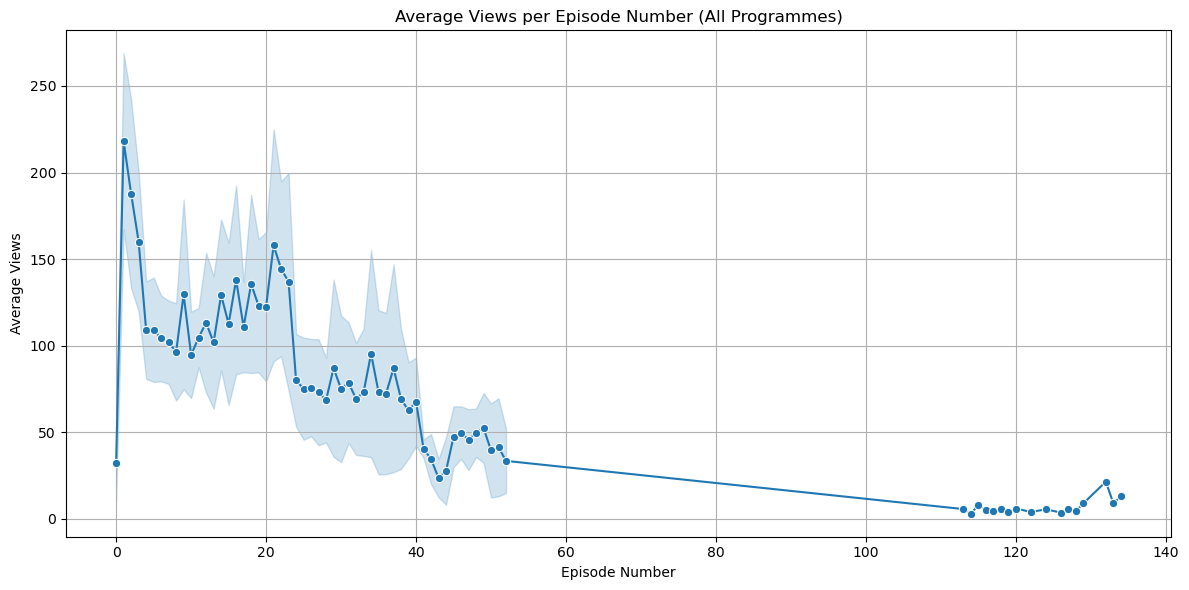

In [57]:
# Average views per episode number across all programmes
avg_views_per_episode = final_df_without_quality.groupby("parsed_episode")["Total_Views"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_views_per_episode, x="parsed_episode", y="Total_Views", marker="o")
plt.title("Average Views per Episode Number (All Programmes)")
plt.xlabel("Episode Number")
plt.ylabel("Average Views")
plt.grid(True)
plt.tight_layout()
plt.show()

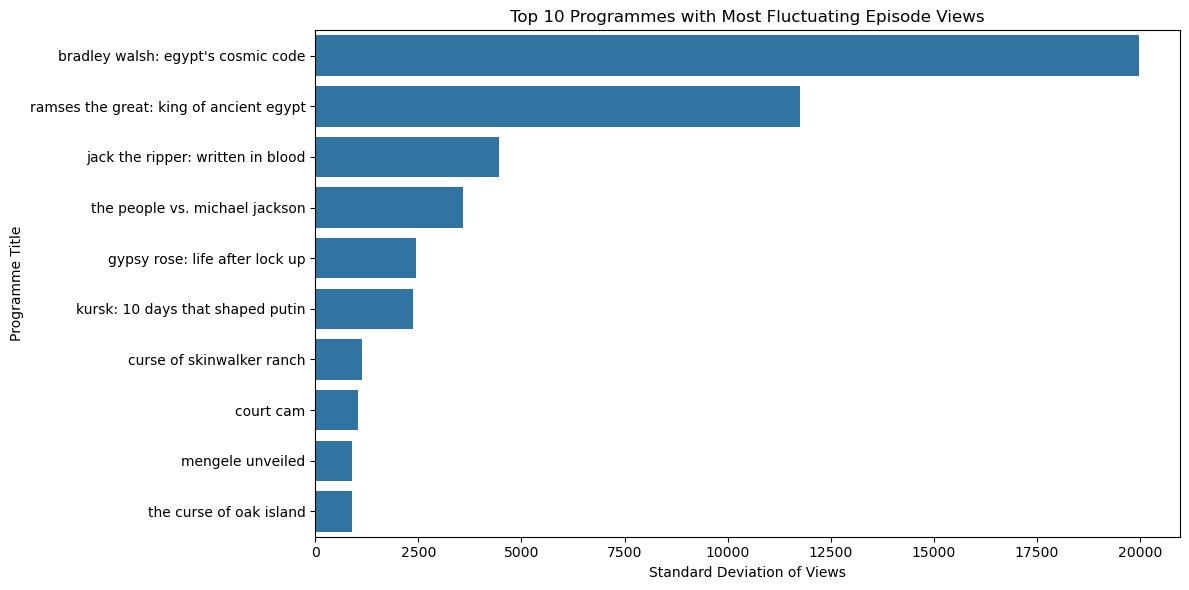

In [59]:
# Viewership consistency - Std deviation of episode views per programme
view_std_per_programme = final_df_without_quality.groupby("matched_programme_title")["Total_Views"].std().reset_index()
view_std_per_programme.columns = ["matched_programme_title", "View_STD"]
view_std_top = view_std_per_programme.sort_values("View_STD", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=view_std_top, y="matched_programme_title", x="View_STD")
plt.title("Top 10 Programmes with Most Fluctuating Episode Views")
plt.xlabel("Standard Deviation of Views")
plt.ylabel("Programme Title")
plt.tight_layout()
plt.show()

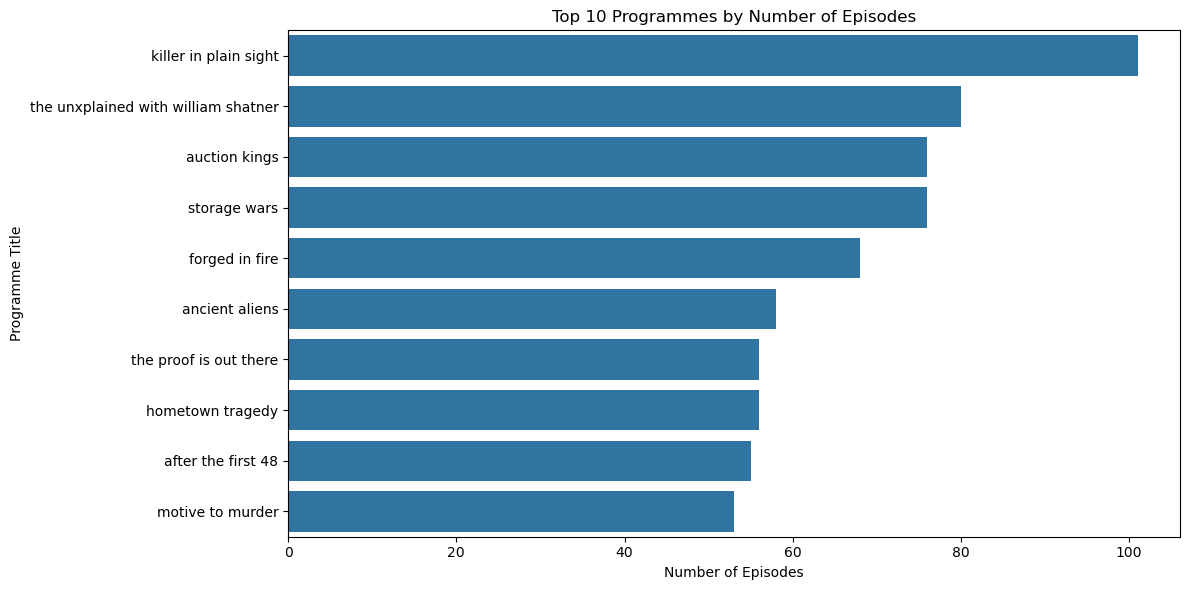

In [61]:
# Episode count per programme (could relate to longevity vs popularity)
episode_counts = final_df_without_quality.groupby("matched_programme_title")["parsed_episode"].nunique().reset_index()
episode_counts.columns = ["matched_programme_title", "Episode_Count"]
episode_counts_top = episode_counts.sort_values("Episode_Count", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=episode_counts_top, y="matched_programme_title", x="Episode_Count")
plt.title("Top 10 Programmes by Number of Episodes")
plt.xlabel("Number of Episodes")
plt.ylabel("Programme Title")
plt.tight_layout()
plt.show()

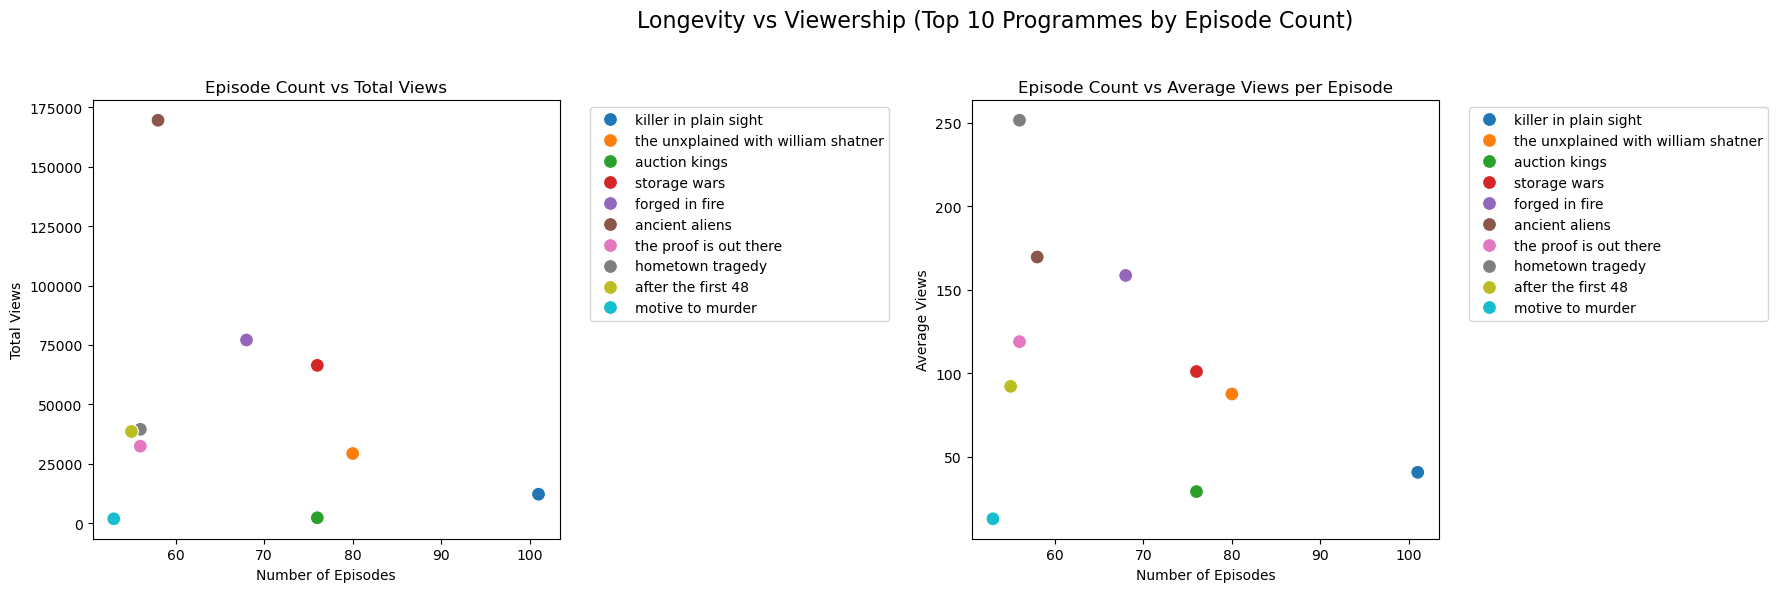

,matched_programme_title,Episode_Count,Total_Views,Average_Views
7,hometown tragedy,56,39478,251.452229
5,ancient aliens,58,169608,169.608000
4,forged in fire,68,77078,158.596708
6,the proof is out there,56,32359,118.966912
3,storage wars,76,66404,101.071537
8,after the first 48,55,38537,92.193780
1,the unxplained with william shatner,80,29270,87.634731
0,killer in plain sight,101,12143,40.748322
2,auction kings,76,2221,29.223684
9,motive to murder,53,1785,12.934783


In [63]:
# Get the top 10 programmes by number of episodes
top_10_episode_programmes = episode_counts_top["matched_programme_title"].tolist()

# Filter original dataframe to only include these programmes
top10_episode_df = final_df_without_quality[final_df_without_quality["matched_programme_title"].isin(top_10_episode_programmes)]

# Calculate total views and average views for each programme
programme_view_stats = top10_episode_df.groupby("matched_programme_title")["Total_Views"].agg(
    Total_Views="sum", Average_Views="mean").reset_index()

# Merge with episode counts
programme_stats_combined = pd.merge(episode_counts_top, programme_view_stats, on="matched_programme_title")

# Set up a 1x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Longevity vs Viewership (Top 10 Programmes by Episode Count)", fontsize=16)

# Plot: Number of Episodes vs. Total Views
sns.scatterplot(data=programme_stats_combined, x="Episode_Count", y="Total_Views",
                hue="matched_programme_title", s=100, ax=axs[0])
axs[0].set_title("Episode Count vs Total Views")
axs[0].set_xlabel("Number of Episodes")
axs[0].set_ylabel("Total Views")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot: Number of Episodes vs. Average Views
sns.scatterplot(data=programme_stats_combined, x="Episode_Count", y="Average_Views",
                hue="matched_programme_title", s=100, ax=axs[1])
axs[1].set_title("Episode Count vs Average Views per Episode")
axs[1].set_xlabel("Number of Episodes")
axs[1].set_ylabel("Average Views")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Layout adjustment
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

programme_stats_combined.sort_values(by="Average_Views", ascending=False)


In [69]:
# Safely convert 'parsed_episode' to numeric (non-numeric values will be set to NaN)
final_df_without_quality["parsed_episode"] = pd.to_numeric(
    final_df_without_quality["parsed_episode"], errors="coerce"
).astype("Int64")

# Convert 'parsed_season' to string
final_df_without_quality["parsed_season"] = final_df_without_quality["parsed_season"].astype(str)

# Get the top 5 most viewed programmes
program_total_views = final_df_without_quality.groupby("matched_programme_title")["Total_Views"] \
                                              .sum().sort_values(ascending=False).reset_index()

top5_programmes = program_total_views.head(5)["matched_programme_title"].tolist()
top5_df = final_df_without_quality[final_df_without_quality["matched_programme_title"].isin(top5_programmes)]

# Calculate viewer loyalty by comparing the first and last episode average views
first_episodes = final_df_without_quality[final_df_without_quality["parsed_episode"] == 1] \
    .groupby("matched_programme_title")["Total_Views"].mean().reset_index(name="First_Episode_Views")

# Identify the maximum episode number for each programme (last episode)
last_episodes = final_df_without_quality.groupby("matched_programme_title")["parsed_episode"].max().reset_index()

# Merge to get last episode view counts
last_episodes_df = pd.merge(final_df_without_quality, last_episodes, on=["matched_programme_title", "parsed_episode"])
last_episodes_df = last_episodes_df.groupby("matched_programme_title")["Total_Views"].mean().reset_index(name="Last_Episode_Views")

# Merge first and last episode views and calculate change
loyalty_df = pd.merge(first_episodes, last_episodes_df, on="matched_programme_title")
loyalty_df["Change"] = loyalty_df["Last_Episode_Views"] - loyalty_df["First_Episode_Views"]
loyalty_df["% Change"] = (loyalty_df["Change"] / loyalty_df["First_Episode_Views"]) * 100

# Sort programmes by percentage drop in viewership
loyalty_df_sorted = loyalty_df.sort_values("% Change")

# Display the final sorted loyalty dataframe
display(loyalty_df_sorted)

,matched_programme_title,First_Episode_Views,Last_Episode_Views,Change,% Change
160,gypsy rose: life after lock up,2034.333333,58.000000,-1976.333333,-97.148943
26,alone,146.666667,5.000000,-141.666667,-96.590909
296,ramses the great: king of ancient egypt,12609.500000,451.000000,-12158.500000,-96.423332
97,cops,782.000000,35.666667,-746.333333,-95.439045
233,lost cities of the trojans,66.333333,5.500000,-60.833333,-91.708543
...,...,...,...,...,...
380,the people vs. michael jackson,2666.000000,6757.500000,4091.500000,153.469617
204,inside the tower of london,34.000000,86.333333,52.333333,153.921569
3,60 days in,3.000000,9.000000,6.000000,200.000000
27,alone: frozen,10.000000,41.000000,31.000000,310.000000
